# Data augmentation

In the original dataset, the classes are unevenly distributed: about 75% of the headlines are classified as `Honest`, and only about 25% are `Clickbait`. To solve that problem, we're going to use the **back translation** method for data augmentation. Using the `googletrans` module, we're going to pass the headings to a chain of automatic translators (*Google Translate*) from one language to another.

Then, we're going to filter the resulting headlines to ensure that they are not too similar to the original sentences. To do that, we're using the *ROUGE* score and the `rouge_score` module. Back-translated headlines with high *ROUGE* are not used for the augmentation.

## Requirements

In [1]:
!pip install numpy pymorphy2 rouge-score
!pip install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 64.7 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=4aa84ad205f699deb0e1356a487197aa17b15c0d0dde4e12158bb289faa7b555
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=7f62b124157fc040375098a6f26a11541f21defa764514021766bb7184f563ab
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built rouge-score docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/sim

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import nltk, pymorphy2, random, re
from googletrans import Translator
from rouge_score import rouge_scorer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
translator = Translator()
rouge_metric = "rougeL"
rouge = rouge_scorer.RougeScorer([rouge_metric])
morph = pymorphy2.MorphAnalyzer()

## Data

In [5]:
!wget https://raw.githubusercontent.com/BunnyNoBugs/hse-headlines-project/main/data/train.csv
#!wget https://raw.githubusercontent.com/BunnyNoBugs/hse-headlines-project/main/data/test.csv

train_data_filename="train.csv"

--2023-03-30 21:42:23--  https://raw.githubusercontent.com/BunnyNoBugs/hse-headlines-project/main/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175396 (171K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 171.29K  --.-KB/s    in 0.004s  

2023-03-30 21:42:23 (38.5 MB/s) - ‘train.csv’ saved [175396/175396]



In [6]:
train_df = pd.read_csv(train_data_filename)
train_df = train_df[train_df["Type"] != "Dishonest"]
train_df

,Headline,Type,Manipulative Device
0,В Питере семь лет простоял памятник не тому че...,Honest,Assertion
1,США официально объявили о новых санкциях проти...,Honest,Assetion
2,Facebook удалил страницу обсуждения штурма «Зо...,Honest,Assertion
3,Джонсон способен развалить Британию,Clickbait,"False actuality inference, Other inference(Sem..."
4,Спортсмен–парапланерист из Москвы погиб в гора...,Honest,Assertion
...,...,...,...
1188,«Шашлык Live» собрал аншлаг. Почему о фестивал...,Honest,"Assertion, Quote"
1189,Роналду заговорил по-русски,Clickbait,False quality inference
1190,Двое мужчин в гаражах забили насмерть человека,Honest,Assertion
1191,SSJ-100 СОВЕРШИЛ ЭКСТРЕННУЮ ПОСАДКУ В САМАРЕ И...,Honest,Assertion


In [7]:
for t in train_df["Type"].unique():
    n = len(train_df[train_df["Type"]==t])
    print(t, n, round(n/len(train_df["Type"]), 2))

Honest 883 0.76
Clickbait 282 0.24


## Back translation

In [8]:
s = train_df["Headline"][0]
s

'В Питере семь лет простоял памятник не тому человеку'

We're using two chains of translations to get two different back-translations for each headline. One is *Russian → Kartuli (Georgian) → Czech → Russian*, the other is *Russian → Hebrew → Korean → Russian*. Different languages were tried out experimentally to achieve the optimal balance of aberration and semantic identity.

In [9]:
def backtrans(sentence, chain, n=1):
    if chain=="ka-cs":    # Kartuli and Czech
        for i in range(n):
            ka_sentence  = translator.translate(sentence,    dest="ka", src="ru").text
            cs_sentence  = translator.translate(ka_sentence, dest="cs", src="ka").text
            sentence     = translator.translate(cs_sentence, dest="ru", src="cs").text

    elif chain=="he-ko":   # Hebrew and Korean
        for i in range(n):
            he_sentence  = translator.translate(sentence,    dest="he", src="ru").text
            ko_sentence  = translator.translate(he_sentence, dest="ko", src="he").text
            sentence     = translator.translate(ko_sentence, dest="ru", src="ko").text

    return sentence

In [10]:
print(s, backtrans(s, chain="ka-cs"), sep="\n")

В Питере семь лет простоял памятник не тому человеку
Семь лет в Петербурге стоял памятник не тому человеку


We're computing *ROUGE* score for the generated headlines and filter out those with a high score. The threshold is `0.9`. Before the measurements, all tokens are normalized with `pymorphy2`.

In [11]:
def similarity(s, bs):
    slovar = set()
    s_n, bs_n = [], []

    for token in word_tokenize(s):
        token = morph.parse(token)[0].normal_form
        s_n.append(token)
        slovar.add(token)

    for token in word_tokenize(bs):
        token = morph.parse(token)[0].normal_form
        bs_n.append(token)
        slovar.add(token)
    
    slovar = list(slovar)
    slovar = {slovar[i]: i for i in range(len(slovar))}
    s_n  = " ".join(str([slovar[w] for w in s_n]))
    bs_n = " ".join(str([slovar[w] for w in bs_n]))
    return rouge.score(s_n, bs_n)[rouge_metric].fmeasure

Let's see some examples of back-translated headlines:

In [12]:
for i in range(7):
    s = train_df["Headline"][i]
    bs_ka_cs = backtrans(s, chain="ka-cs")
    bs_he_ko = backtrans(s, chain="he-ko")
    print(f"Original:\t\t\t{s}",
          f"Backtranslated ('ka-cs'):\t{bs_ka_cs}",
          f"{rouge_metric} F-measure ('ka-cs'):\t{round(similarity(s, bs_ka_cs), 3)}",
          f"Backtranslated ('he-ko'):\t{bs_he_ko}",
          f"{rouge_metric} F-measure ('he-ko'):\t{round(similarity(s, bs_he_ko), 3)}",
          sep="\n", end="\n\n")

Original:			В Питере семь лет простоял памятник не тому человеку
Backtranslated ('ka-cs'):	Семь лет в Петербурге стоял памятник не тому человеку
rougeL F-measure ('ka-cs'):	0.632
Backtranslated ('he-ko'):	Памятник Не тому человеку стоит в Петербурге 7 лет
rougeL F-measure ('he-ko'):	0.4

Original:			США официально объявили о новых санкциях против РФ по делу Скрипалей
Backtranslated ('ka-cs'):	США официально объявили о новых санкциях против России из-за дела Скрипалей
rougeL F-measure ('ka-cs'):	0.815
Backtranslated ('he-ko'):	США официально объявили о новых санкциях против России в связи с делом Скрипаля
rougeL F-measure ('he-ko'):	0.765

Original:			Facebook удалил страницу обсуждения штурма «Зоны 51»
Backtranslated ('ka-cs'):	Facebook закрывает страницу обсуждения Зоны 51
rougeL F-measure ('ka-cs'):	0.667
Backtranslated ('he-ko'):	Facebook удаляет страницу обсуждения Зоны 51.
rougeL F-measure ('he-ko'):	0.667

Original:			Джонсон способен развалить Британию
Backtranslated ('ka-cs'):	

In [13]:
def pipeline(s, chain):
    bs = backtrans(s, chain)
    if similarity(s, bs) < 0.9:
        return bs
    return None

## Application

We're creating another column in our dataset to mark which headlines are back-translated.

In [14]:
train_df["Augmented"] = False
train_df

,Headline,Type,Manipulative Device,Augmented
0,В Питере семь лет простоял памятник не тому че...,Honest,Assertion,False
1,США официально объявили о новых санкциях проти...,Honest,Assetion,False
2,Facebook удалил страницу обсуждения штурма «Зо...,Honest,Assertion,False
3,Джонсон способен развалить Британию,Clickbait,"False actuality inference, Other inference(Sem...",False
4,Спортсмен–парапланерист из Москвы погиб в гора...,Honest,Assertion,False
...,...,...,...,...
1188,«Шашлык Live» собрал аншлаг. Почему о фестивал...,Honest,"Assertion, Quote",False
1189,Роналду заговорил по-русски,Clickbait,False quality inference,False
1190,Двое мужчин в гаражах забили насмерть человека,Honest,Assertion,False
1191,SSJ-100 СОВЕРШИЛ ЭКСТРЕННУЮ ПОСАДКУ В САМАРЕ И...,Honest,Assertion,False


Then, we're augmenting clickbait headlines.

In [15]:
def augment_clickbait(df):
    click_df = df[df["Type"] == "Clickbait"]
    augment_df = pd.DataFrame(columns=click_df.columns)

    for chain in ("ka-cs", "he-ko"):
        for i in tqdm(range(len(click_df))):
            bs = pipeline(click_df.iloc[i]["Headline"], chain=chain)
            if bs:
                augment_df = augment_df.append(click_df.iloc[i], ignore_index=True)
                n = len(augment_df)-1
                augment_df["Headline"][n], augment_df["Augmented"][n] = bs, True
    
    return df.append(augment_df, ignore_index=True)

In [16]:
augmented_df = augment_clickbait(train_df)
augmented_df

100%|██████████| 282/282 [00:46<00:00,  6.05it/s]


,Headline,Type,Manipulative Device,Augmented
0,В Питере семь лет простоял памятник не тому че...,Honest,Assertion,False
1,США официально объявили о новых санкциях проти...,Honest,Assetion,False
2,Facebook удалил страницу обсуждения штурма «Зо...,Honest,Assertion,False
3,Джонсон способен развалить Британию,Clickbait,"False actuality inference, Other inference(Sem...",False
4,Спортсмен–парапланерист из Москвы погиб в гора...,Honest,Assertion,False
...,...,...,...,...
1633,Покупатели спиртных напитков будут в ужасе от ...,Clickbait,False actuality inference,True
1634,Обновление Windows убило мой ноутбук Lenovo.,Clickbait,"Other inference(Hyperbole), Other inference(Se...",True
1635,Министр обороны Великобритании угрожает России,Clickbait,"False actuality inference, Other inference(Sem...",True
1636,Спинное кольцо готово. Сторонники свободных вы...,Clickbait,False referentiality inference,True


Let's see how the proportion of classes has changed.

In [56]:
stats = pd.DataFrame(columns=["aug", "type", "n", "p"])

print("Original dataframe:")
for t in train_df["Type"].unique():
    n = len(train_df[train_df["Type"]==t])
    p = round(n/len(train_df["Type"]), 2)
    row = {"aug": "original", "type": t, "n": n, "p": p}
    stats = stats.append(pd.Series(row), ignore_index=True)
    print(t, n, p)

print("\nAugmented dataframe:")
for t in augmented_df["Type"].unique():
    n = len(augmented_df[augmented_df["Type"]==t])
    p = round(n/len(augmented_df["Type"]), 2)
    row = {"aug": "augmented", "type": t, "n": n, "p": p}
    stats = stats.append(pd.Series(row), ignore_index=True)
    print(t, n, p)

click_df = augmented_df[augmented_df["Type"]=="Clickbait"]
for t in click_df["Augmented"].unique():
    n = len(click_df[click_df["Augmented"]==t])
    print("---", f"Augmented_{t}", n, round(n/len(click_df["Augmented"]), 2))

Original dataframe:
Honest 883 0.76
Clickbait 282 0.24

Augmented dataframe:
Honest 883 0.54
Clickbait 755 0.46
--- Augmented_False 282 0.37
--- Augmented_True 473 0.63


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='aug', ylabel='n'>

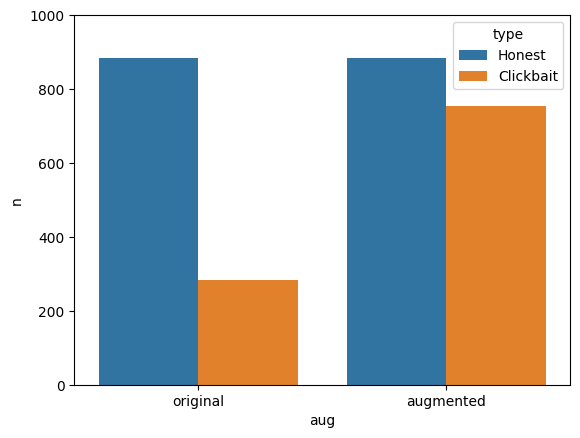

In [60]:
plt.ylim(0, 1000)
sns.barplot(x="aug", y="n", data=stats, hue="type")

Hooray! The classes are almost identical in size.

In [18]:
augmented_df.to_csv("augmented_train.csv")